In [1]:
import json

import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import torch
import pickle
from itertools import combinations
import os
import nibabel as nib
from collections import defaultdict
import random

In [2]:
def crop_to_vessel(img, vessel_mask, crop_factor=1.0, width_vario=0.5, height_vario=0.5):
    """
    Crop the image to the vessel mask.

    :param img: input image
    :param vessel_mask: vessel mask
    :param crop_factor: crop factor, 1.0 for exact bounding box of vessel mask, >1.0 for larger areas
    :param width_vario: positional shift of vessel in horizontal direction
    :param height_vario: positional shift of vessel in vertical direction
    :return: cropped image
    """

    # Find contours in the vessel_mask
    contours, _ = cv2.findContours(vessel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box around the vessel_mask
    x, y, w, h = cv2.boundingRect(contours[0])

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Determine the size of the square
    cropped_width = w * crop_factor
    cropped_height = h * crop_factor

    x1 = max(0, center_x - int(cropped_width * width_vario))
    y1 = max(0, center_y - int(cropped_height * height_vario))
    x2 = min(img.shape[1], center_x + int(cropped_width * (1-width_vario)))
    y2 = min(img.shape[0], center_y + int(cropped_height * (1-height_vario)))

    # Crop the image to the square
    return img[y1:y2, x1:x2]

In [3]:
def read_selection_from_json(file_path):
    """
    Reads selection criteria from a JSON file.

    :param file_path: path to JSON file
    :return: selection criteria
    """
    with open(file_path, 'r') as f:
        selection_data = json.load(f)

    selection = {}
    for subfolder, data in selection_data.items():
        ranges = [(int(start), int(end)) for range_str in data["ranges"] for start, end in [range_str.split('-')]]
        step_size = data["step_size"]
        selection[subfolder] = {"ranges": ranges, "step_size": step_size}

    return selection

In [7]:
def create_healthy_datasets(healthy_selection_json, dataset_path, show_images=False):
    """
    Create healthy datasets from the selected healthy images.

    :param healthy_selection_json: selected healthy images
    :param dataset_path: path to data
    :param show_images: boolean to show images
    :return: healthy training and test datasets
    """
    healthy_selection = read_selection_from_json(healthy_selection_json)

    image_dataset = []

    number_of_images = []
    folders = []

    for data_path, selection in healthy_selection.items():
        print(f"Processing {data_path}")
        current_image_dataset = []
        slice_ranges = selection["ranges"]
        image_step_size = selection["step_size"]

        for start_index, end_index in slice_ranges:
            image_files = sorted(glob.glob(f"/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/healthy/{data_path}/img/*.png"))[start_index - 1: end_index]
            vessel_files = sorted(glob.glob(f"/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/healthy/{data_path}/vessel/*.png"))[start_index - 1: end_index]

            for i, img_id in enumerate(range(0, len(image_files), image_step_size)):
                img = cv2.imread(image_files[img_id])[:, :, 0]
                vessel_mask = cv2.imread(vessel_files[img_id], cv2.IMREAD_GRAYSCALE)

                # augmentation
                crop_factor = np.random.uniform(1.1, 1.5)
                width_vario = np.random.uniform(0.46, 0.54)
                height_vario = np.random.uniform(0.46, 0.54)

                cropped_image = crop_to_vessel(img, vessel_mask, crop_factor, width_vario, height_vario)
                current_image_dataset.append(cropped_image)
                # if show_images:
                #     plt.figure()
                #     plt.subplot(1, 3, 1)
                #     plt.imshow(img, cmap="gray")
                #     plt.title("Original Image")
                #     plt.subplot(1, 3, 2)
                #     plt.imshow(vessel_mask, cmap="gray")
                #     plt.title("Vessel mask")
                #     plt.subplot(1, 3, 3)
                #     plt.imshow(cropped_image, cmap="gray")
                #     plt.title("Cropped Image")
                #     plt.tight_layout()
                #     plt.suptitle(f"{data_path}, {img_id}, {i}")
                #     plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
                #     plt.show()


        image_dataset.append(current_image_dataset)

        number_of_images.append(len(current_image_dataset))
        folders.append(data_path)
    return image_dataset, number_of_images, folders

In [5]:
def split_dataset(folder_names, image_counts, folder_to_subject, target_train_size):
    # Group folders by subjects
    subject_to_folders = defaultdict(list)
    subject_to_image_counts = defaultdict(int)
    
    for folder, count in zip(folder_names, image_counts):
        subject = folder_to_subject[folder]
        subject_to_folders[subject].append(folder)
        subject_to_image_counts[subject] += count
    
    # Sort subjects by total image count (descending order for greedy selection)
    sorted_subjects = sorted(subject_to_folders.keys(), key=lambda s: subject_to_image_counts[s], reverse=True)
    
    train_indices = set()
    test_indices = set(range(len(folder_names)))
    current_train_size = 0
    
    # Greedy selection of subjects to reach target as closely as possible
    for subject in sorted_subjects:
        subject_folders = subject_to_folders[subject]
        subject_size = subject_to_image_counts[subject]
        
        if current_train_size + subject_size <= target_train_size:
            for folder in subject_folders:
                index = folder_names.index(folder)
                train_indices.add(index)
                test_indices.discard(index)
            current_train_size += subject_size
    
    return list(train_indices), list(test_indices)

In [8]:
healthy_selection_json = '/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/healthy_image_selection.json'
dataset_path = '1'
image_dataset, number_of_images, folders = create_healthy_datasets(healthy_selection_json, dataset_path, show_images=False)

Processing continous/carotid/1
Processing continous/carotid/2
Processing continous/carotid/3
Processing continous/carotid/4
Processing continous/carotid/5
Processing continous/carotid/6
Processing continous/carotid/7
Processing continous/carotid/8
Processing continous/carotid/9
Processing lucie/1
Processing lucie/2
Processing lucie/3
Processing camp_lab/1
Processing camp_lab/2
Processing camp_lab/3
Processing camp_lab/4
Processing camp_lab/5
Processing camp_lab/6
Processing camp_lab/7
Processing camp_lab/8
Processing camp_lab/9
Processing camp_lab/10
Processing camp_lab/11
Processing camp_lab/12
Processing camp_lab/13
Processing camp_lab/14
Processing camp_lab/15
Processing camp_lab/16
Processing camp_lab/17
Processing camp_lab/18
Processing camp_lab/19
Processing camp_lab/20
Processing camp_lab/21
Processing camp_lab/22
Processing camp_lab/23
Processing camp_lab/24
Processing camp_lab/25
Processing camp_lab/26
Processing camp_lab/27
Processing camp_lab/28
Processing camp_lab/29
Proces

In [13]:
folder_to_subject = {
    "continous/carotid/1": "Dianye",
    "continous/carotid/2": "Dianye",
    "continous/carotid/3": "Dianye",
    "continous/carotid/4": "Yuan Bi",
    "continous/carotid/5": "Yuan Bi",
    "continous/carotid/6": "Yuan Bi",
    "continous/carotid/7": "Zhongliang",
    "continous/carotid/8": "Zhongliang",
    "continous/carotid/9": "Zhongliang",
    "lucie/1": "Lucie",
    "lucie/2": "Lucie",
    "lucie/3": "Lucie",
    "camp_lab/1": "Yang Su",
    "camp_lab/2": "Yang Su",
    "camp_lab/3": "Yang Su",
    "camp_lab/4": "Person 1",
    "camp_lab/5": "Person 1",
    "camp_lab/6": "Zhongyu",
    "camp_lab/7": "Zhongyu",
    "camp_lab/8": "Zhongyu",
    "camp_lab/9": "Felix H",
    "camp_lab/10": "Felix H",
    "camp_lab/11": "Person 2",
    "camp_lab/12": "Person 2",
    "camp_lab/13": "Person 2",
    "camp_lab/14": "David",
    "camp_lab/15": "David",
    "camp_lab/16": "Chantal",
    "camp_lab/17": "Chantal",
    "camp_lab/18": "Ege",
    "camp_lab/19": "Ege",
    "camp_lab/20": "Francesca",
    "camp_lab/21": "Francesca",
    "camp_lab/22": "Lennard",
    "camp_lab/23": "Lennard",
    "camp_lab/24": "Kevin",
    "camp_lab/25": "Kevin",
    "camp_lab/26": "Unknown",
    "camp_lab/27": "Feng",
    "camp_lab/28": "Feng",
    "camp_lab/29": "Magda",
    "camp_lab/30": "Magda",
    "camp_lab/31": "Hong Joo",
    "camp_lab/32": "Hong Joo",
    "camp_lab/33": "Vanessa",
    "camp_lab/34": "Vanessa",
    "camp_lab/35": "Dianye",
    "camp_lab/36": "Dianye",
    "camp_lab/37": "Xuesong",
    "camp_lab/38": "Xuesong",
    "camp_lab/39": "Felix D",
    "camp_lab/40": "Felix D",
    "camp_lab/41": "Dani",
    "camp_lab/42": "Dani",
    "camp_lab/43": "Dani",
    "camp_lab/44": "Lucie",
    "camp_lab/45": "Dian Gong",
    "camp_lab/46": "Dian Gong"
}

In [14]:
train_folders, test_folders = split_dataset(folders, number_of_images, folder_to_subject, 7306)
print("Train folders:", train_folders)
print("Test folders:", test_folders)

Train folders: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 20, 21, 25, 26, 27, 28, 31, 32, 37, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 55, 56, 57]
Test folders: [15, 16, 17, 18, 19, 22, 23, 24, 29, 30, 33, 34, 35, 36, 38, 39, 48, 49]


In [15]:
training_numbers = [number_of_images[i] for i in train_folders]
test_numbers = [number_of_images[i] for i in test_folders]
print("Subset close to target (values):", np.sum(training_numbers))
print("Remaining numbers (values):", np.sum(test_numbers))

Subset close to target (values): 7285
Remaining numbers (values): 833


In [17]:
train_healthy_data = [image for i in train_folders for image in image_dataset[i]]
test_healthy_data = [image for i in test_folders for image in image_dataset[i]]
print(len(train_healthy_data))

with open(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/train_healthy_dataset_new.pkl", "wb") as f:
    pickle.dump(train_healthy_data, f)
with open(f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/Ultrasound/test_healthy_dataset_new.pkl", "wb") as f:
    pickle.dump(test_healthy_data, f)

7285


In [11]:
len(image_dataset)

58

# Brats23

In [2]:
def create_healthy_and_anomalous_list(data_path):
    """
    Create lists of healthy and anomalous patients and brain slices.

    :param data_path: path to data
    :param output_path: path to save output
    """

#     df = pd.read_excel(f"{data_path}/BraTS2023_2017_GLI_Mapping.xlsx")
#     brats23_column = df["BraTS2023"]
#     all_patients = [element[len("BraTS-GLI-"):] for element in brats23_column if
#                     isinstance(element, str) and element.startswith("BraTS-GLI-")]

    all_patients = os.listdir(data_path)
    all_patients.sort()

    brain_slices = np.arange(80, 100)  # between 80 and 100 best; also tried (50, 121)

    healthy_list = []
    anomalous_patient_list = []
    healthy_patient_list = []
    number_of_healthy_list = []

    for patient in all_patients:
        current_healthy_list = []
        path = f"{data_path}/{patient}/{patient}"
        seg = nib.load(f"{path}-seg.nii.gz").get_fdata()
        volume = nib.load(f"{path}-t2f.nii.gz").get_fdata()

        for brain_slice in brain_slices:
            seg_slice = seg[:, :, brain_slice]

            if np.all(seg_slice == 0):  # No tumor
                current_healthy_list.append(volume[:, :, brain_slice])
        if len(current_healthy_list) > 0:
            healthy_patient_list.append(patient)
            number_of_healthy_list.append(len(current_healthy_list))
            healthy_list.append(current_healthy_list)
        else:
            anomalous_patient_list.append(patient)

#     healthy_list_path = f"{output_path}/healthy_list.npy"
#     anomalous_list_path = f"{output_path}/anomalous_list.npy"
    
    return healthy_list, healthy_patient_list, number_of_healthy_list, anomalous_patient_list

#     np.save(healthy_list_path, np.array(healthy_list))
#     np.save(anomalous_list_path, np.array(anomalous_list))

#     print(f"Healthy list saved as {healthy_list_path}.")
#     print(f"Anomalous list saved as {anomalous_list_path}.")

In [ ]:
def divide_list_by_index(nums, target):
    n = len(nums)
    # Create a DP table where dp[i][j] indicates if sum j can be achieved using the first i elements
    dp = [[False] * (target + 1) for _ in range(n + 1)]
    dp[0][0] = True  # Base case: sum of 0 is possible with 0 elements

    # Track how each sum is achieved
    parent = [[-1] * (target + 1) for _ in range(n + 1)]

    # Fill the DP table
    for i in range(1, n + 1):
        for j in range(target + 1):
            if dp[i - 1][j]:  # If sum j is achievable without current element
                dp[i][j] = True
                parent[i][j] = j
            if j >= nums[i - 1] and dp[i - 1][j - nums[i - 1]]:  # If sum j is achievable by including current element
                dp[i][j] = True
                parent[i][j] = j - nums[i - 1]

    # Find the closest sum to the target
    closest_sum = -1
    for j in range(target, -1, -1):
        if dp[n][j]:
            closest_sum = j
            break

    # Backtrack to find the subset
    subset_indices = []
    i, j = n, closest_sum
    while i > 0 and j >= 0:
        if parent[i][j] != j:  # If this element was included in the subset
            subset_indices.append(i - 1)
            j = parent[i][j]
        i -= 1

    # Remaining indices
    subset_indices = set(subset_indices)
    remaining_indices = [i for i in range(n) if i not in subset_indices]

    return list(subset_indices), remaining_indices

In [3]:
data_path = '/home/camp/Projects/Yuan/Data/brats23/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData'
healthy_list, healthy_patient_list, number_of_healthy_list, anomalous_patient_list = create_healthy_and_anomalous_list(data_path)

In [13]:
print(len(healthy_patient_list))
print(len(anomalous_patient_list))


372
879


In [15]:
len(healthy_list)

4159

In [7]:
subset_indices, remaining_indices = divide_list_by_index(number_of_healthy_list, 3743)

In [8]:
subset_numbers = [number_of_healthy_list[i] for i in subset_indices]
remaining_numbers = [number_of_healthy_list[i] for i in remaining_indices]
print("Subset close to target (values):", np.sum(subset_numbers))
print("Remaining numbers (values):", np.sum(remaining_numbers))

Subset close to target (values): 3743
Remaining numbers (values): 416


In [11]:
train_healthy_data = [image for i in subset_indices for image in healthy_list[i]]
test_healthy_data = [image for i in remaining_indices for image in healthy_list[i]]
print(len(train_healthy_data))

np.save('/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/train_healthy_dataset_new.npy',np.array(train_healthy_data))
np.save('/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_healthy_dataset_new.npy',np.array(test_healthy_data))


3743


In [12]:
del healthy_list, train_healthy_data, test_healthy_data

In [20]:
anomalous_list = []
brain_slices = np.arange(80, 100)
for patient in anomalous_patient_list:
    path = f"{data_path}/{patient}/{patient}"
    seg = nib.load(f"{path}-seg.nii.gz").get_fdata()
    volume = nib.load(f"{path}-t2f.nii.gz").get_fdata()

    for brain_slice in brain_slices:
        seg_slice = seg[:, :, brain_slice]

        if not np.all(seg_slice ==0):  # Tumor
            anomalous_list.append([patient, brain_slice])

In [19]:
len(anomalous_patient_list)+len(healthy_patient_list)

1251

In [26]:
num_test_data = 1000
anomalous_list = np.array(anomalous_list)
anomalous_dataset = np.zeros((num_test_data, 240, 240), dtype=np.float64)
anomalous_masks = np.zeros((num_test_data, 240, 240), dtype=np.float64)

test_anomalous_list = anomalous_list[np.random.choice(anomalous_list.shape[0], num_test_data, replace=False), :]
for i, (patient, brain_slice) in enumerate(test_anomalous_list):
    path = f"{data_path}/{patient}/{patient}"
    anomalous_dataset[i] = nib.load(f"{path}-t2f.nii.gz").get_fdata()[:, :, int(brain_slice)]
    anomalous_masks[i] = nib.load(f"{path}-seg.nii.gz").get_fdata()[:, :, int(brain_slice)]
print(f"Test anomalous dataset: {len(anomalous_dataset)}.")

test_dataset_path = f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_anomalous_dataset_new.npy"
test_masks_path = f"/home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_anomalous_masks_new.npy"
np.save(test_dataset_path, anomalous_dataset)
np.save(test_masks_path, anomalous_masks)
print(f"Test anomalous dataset and mask saved as {test_dataset_path} and {test_masks_path}.")

Test anomalous dataset: 1000.
Test anomalous dataset and mask saved as /home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_anomalous_dataset_new.npy and /home/camp/Projects/Yuan/thesis_diffusion-main/output/BraTS/test_anomalous_masks_new.npy.


# Lits

In [2]:
def create_healthy_and_anomalous_list(data_path):
    segmentation_files = os.listdir(f"{data_path}/segmentation")
    segmentation_files.sort()
    volume_files = os.listdir(f"{data_path}/volume")
    volume_files.sort()

    healthy_patient_list = []
    anomalous_patient_list = []
    number_of_healthy_slices = []
    number_of_anomalous_slices = []
    anomalous_slices_by_patient = {}
    patient_slices = {}

    for idx in range(len(volume_files)):
        seg_path = f"{data_path}/segmentation/{segmentation_files[idx]}"
        volume_path = f"{data_path}/volume/{volume_files[idx]}"
        seg = nib.load(seg_path).get_fdata()
        volume = nib.load(volume_path).get_fdata()
        
        volume = np.clip(volume, 0, 150)
        
        count_liver = np.sum(seg == 1, axis=(0, 1))  # Healthy liver tissue area
        count_tumor = np.sum(seg == 2, axis=(0, 1))  # Tumor area

        # Identify healthy and anomalous slices
        healthy_mask = (count_liver > 10000) & (count_tumor == 0)
        anomalous_mask = (count_liver + count_tumor >= 10000) & (count_tumor > 1500)

        num_healthy_slices = np.sum(healthy_mask)
        num_anomalous_slices = np.sum(anomalous_mask)

        patient_id = segmentation_files[idx]
        patient_slices[patient_id] = {
            "healthy_images": np.moveaxis(volume[:, :, healthy_mask], 2, 0).copy(),
            "healthy_liver_masks": np.moveaxis(seg[:, :, healthy_mask] == 1, 2, 0).copy(),  # Save only liver mask
            "anomalous_images": np.moveaxis(volume[:, :, anomalous_mask], 2, 0).copy(), 
            "anomalous_masks": np.moveaxis(seg[:, :, anomalous_mask] == 2, 2, 0).copy()
        }
        
        if num_healthy_slices > 0:
            healthy_patient_list.append(patient_id)
            number_of_healthy_slices.append(num_healthy_slices)

        if num_anomalous_slices > 0:
            anomalous_patient_list.append(patient_id)
            number_of_anomalous_slices.append(num_anomalous_slices)
            anomalous_slices_by_patient[patient_id] = num_anomalous_slices
    
    return healthy_patient_list, number_of_healthy_slices, anomalous_patient_list, number_of_anomalous_slices, anomalous_slices_by_patient, patient_slices

In [3]:
def split_patients(healthy_patients, num_healthy_slices, anomalous_patients, num_anomalous_slices, anomalous_slices_by_patient, patient_slices, target_train_size, save_path):
    # Sort healthy patients by number of slices (descending)
    sorted_healthy = sorted(zip(healthy_patients, num_healthy_slices), key=lambda x: x[1], reverse=True)
    
    train_set = set()
    test_set = set()
    train_size = 0
    
    # Greedy selection for healthy training group
    for patient, count in sorted_healthy:
        if train_size + count <= target_train_size:
            train_set.add(patient)
            train_size += count
        else:
            test_set.add(patient)
    
    # Ensure all healthy images are used
    test_set.update(patient for patient, _ in sorted_healthy if patient not in train_set)
    
    # Select anomalous test set (cannot be from train_set), sampled randomly
    available_anomalous = [p for p in anomalous_patients if p in test_set]
    all_anomalous_slices = [(p, n) for p, n in anomalous_slices_by_patient.items() if p in available_anomalous]
    
    random.shuffle(all_anomalous_slices)  # Shuffle to randomize selection
    anomalous_test_set = set()
    anomalous_test_size = 0
    
    for patient, count in all_anomalous_slices:
        if anomalous_test_size + count <= 1000:
            anomalous_test_set.add(patient)
            anomalous_test_size += count
    
    print(f"Size of Healthy Training Group: {sum(num_healthy_slices[healthy_patients.index(p)] for p in train_set)}")
    print(f"Size of Healthy Test Group: {sum(num_healthy_slices[healthy_patients.index(p)] for p in test_set)}")
    print(f"Size of Anomalous Test Group: {anomalous_test_size}")
    
#     # Save the image sets as .pkl files
#     datasets = {
#         "train_healthy_abdomen_dataset_new": [img for p in train_set for img in patient_slices[p]["healthy_images"]],
#         "train_healthy_liver_masks_new": [img for p in train_set for img in patient_slices[p]["healthy_liver_masks"]],
#         "test_healthy_abdomen_dataset_new": [img for p in test_set for img in patient_slices[p]["healthy_images"]],
#         "test_healthy_liver_masks_new": [img for p in test_set for img in patient_slices[p]["healthy_liver_masks"]],
#         "test_anomalous_abdomen_dataset_new": [img for p in anomalous_test_set for img in patient_slices[p]["anomalous_images"]],
#         "test_anomalous_tumor_masks_new": [img for p in anomalous_test_set for img in patient_slices[p]["anomalous_masks"]]
#     }
    
#     for name, data in datasets.items():
#         with open(f"{save_path}/{name}.pkl", "wb") as f:
#             pickle.dump(data, f)
    
    return list(train_set), list(test_set), list(anomalous_test_set)

In [4]:
data_path = '/home/camp/Projects/Yuan/Data/lits/LITS-Challenge-Training-Data'
save_path = '/home/camp/Projects/Yuan/thesis_diffusion-main/output/LiTS'
healthy_patients, num_healthy_slices, anomalous_patients, num_anomalous_slices, anomalous_slices_by_patient, patient_slices = create_healthy_and_anomalous_list(data_path)
target_train_size = 5820



In [16]:
train, test, anomalous_test = split_patients(healthy_patients, num_healthy_slices, anomalous_patients, num_anomalous_slices, anomalous_slices_by_patient, patient_slices, target_train_size, save_path)


Size of Healthy Training Group: 5820
Size of Healthy Test Group: 647
Size of Anomalous Test Group: 1000


In [17]:
# Save the image sets as .pkl files
datasets = {
    "train_healthy_abdomen_dataset_new": [img for p in train for img in patient_slices[p]["healthy_images"]],
    "train_healthy_liver_masks_new": [img for p in train for img in patient_slices[p]["healthy_liver_masks"]],
    "test_healthy_abdomen_dataset_new": [img for p in test for img in patient_slices[p]["healthy_images"]],
    "test_healthy_liver_masks_new": [img for p in test for img in patient_slices[p]["healthy_liver_masks"]],
    "test_anomalous_abdomen_dataset_new": [img for p in anomalous_test for img in patient_slices[p]["anomalous_images"]],
    "test_anomalous_tumor_masks_new": [img for p in anomalous_test for img in patient_slices[p]["anomalous_masks"]]
}

for name, data in datasets.items():
    with open(f"{save_path}/{name}.pkl", "wb") as f:
        pickle.dump(data, f)

In [18]:
with open(f"../output/LiTS/test_anomalous_abdomen_dataset_new.pkl", "rb") as f:
    data = pickle.load(f)
print(len(data))
# print(np.array(data).shape)

1000


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150]


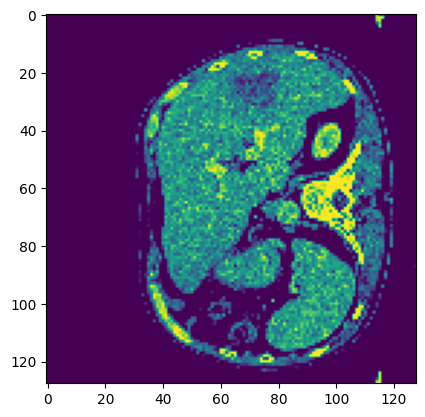

In [16]:
plt.imshow(data[10])
print(np.unique(data[10]))

In [14]:
original_file = f"../output/LiTS/test_anomalous_abdomen_dataset_new.pkl"

with open(original_file, "rb") as f:
    data = pickle.load(f)

# resized_images = [cv2.resize(img.astype(int), (128,128), interpolation=cv2.INTER_NEAREST) for img in data]

resized_images = [cv2.resize(img.astype(int), (128,128), interpolation=cv2.INTER_LINEAR) for img in data]

with open(original_file, "wb") as f:
    pickle.dump(resized_images, f)

In [15]:
np.array(resized_images).shape

(1000, 128, 128)

In [3]:
import os
import pandas as pd
from PIL import Image

In [5]:
# Placeholder paths (replace with actual paths)
CSV_FILE_PATH = "/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/patient_1810_1.csv"
IMAGE_FOLDER = "/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/1/img"
OUTPUT_FOLDER = "/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img"
IMAGE_FORMAT = "png"  # Change this if images have a different format (e.g., png)

# Define range for processing
IMAGE_INDEX_MIN = 72  # Change this to set the minimum index
IMAGE_INDEX_MAX = 85  # Change this to set the maximum index

# Create output folder if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Load the CSV file
df = pd.read_csv(CSV_FILE_PATH)

# Filter images within the specified range
df = df[(df["Unnamed: 0"] >= IMAGE_INDEX_MIN) & (df["Unnamed: 0"] <= IMAGE_INDEX_MAX)]

# List all image files in the folder
image_files = sorted(os.listdir(IMAGE_FOLDER))  # Sorting ensures index consistency

# Iterate through each row in the filtered CSV
total_images = len(df)
for index, row in df.iterrows():
    image_index = row["Unnamed: 0"]  # Assuming first column is the image index
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    
    # Get image by its position in the sorted list
    if image_index < len(image_files):
        image_path = os.path.join(IMAGE_FOLDER, image_files[image_index])
        output_path = os.path.join(OUTPUT_FOLDER, f"cropped_{image_files[image_index]}")
        
        # Open and crop the image
        with Image.open(image_path) as img:
            cropped_img = img.crop((x_min, y_min, x_max, y_max))
            cropped_img.save(output_path)
            print(f"Saved: {output_path}")
    else:
        print(f"Warning: Image index out of range - {image_index}")

print("Cropping completed!")




Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data072.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data073.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data074.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data075.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data076.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data077.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data078.png
Saved: /home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy/Moustafa/18.10.2022/cropped_1/img/cropped_data079.png
Saved: /home/camp/Projects/Yuan/

In [6]:
import os
from PIL import Image

# Set the main directory containing images
folder_path = "/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy_selected"  # Change this to your folder path

# Walk through all subdirectories and files
for root, _, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".png"):  # Only process .png files
            old_path = os.path.join(root, filename)

            # Open the image using Pillow
            img = Image.open(old_path)

            # Convert image to RGB (necessary for .jpg format)
            img = img.convert("RGB")

            # Create new filename
            new_name = filename.replace(".png", ".jpg")
            new_path = os.path.join(root, new_name)

            # Save as JPG
            img.save(new_path, "JPEG", quality=95)  # Adjust quality if needed

            # Optional: Remove the original PNG file after conversion
            os.remove(old_path)

print("Conversion and renaming completed for all PNG files in subfolders!")

Conversion and renaming completed for all PNG files in subfolders!


In [8]:
import os
from PIL import Image
import numpy as np

# Set the main directory containing images
folder_path = "/home/camp/Projects/Yuan/Data/Ultrasound_synomaly/unhealthy_selected"  # Change this to your folder path

# Walk through all subdirectories and files
for root, _, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".png"):  # Only process .png files
            old_path = os.path.join(root, filename)

            # Open the image using Pillow
            img = Image.open(old_path)

            # Convert image to grayscale (to check intensity)
            img_gray = img.convert("L")  # 'L' mode converts to grayscale

            # Convert image to NumPy array and sum pixel values
            img_array = np.array(img_gray)
            intensity_sum = np.sum(img_array)

            # If the sum of all intensities is 0, print the filename
            if intensity_sum == 0:
                print(f"Image with zero intensity: {old_path}")
                continue  # Skip conversion for this image

            # Convert image to RGB (necessary for .jpg format)
            img = img.convert("RGB")

            # Create new filename
            new_name = filename.replace(".png", ".jpg")
            new_path = os.path.join(root, new_name)

            # Save as JPG
            img.save(new_path, "JPEG", quality=95)  # Adjust quality if needed

            # Optional: Remove the original PNG file after conversion
            os.remove(old_path)

print("Conversion completed! Check console for images with zero intensity.")

Conversion completed! Check console for images with zero intensity.
